In [1]:
import tensorflow as tf

2024-04-05 21:03:38.497857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 21:03:40.197593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(1).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
x_train = []
y_train = []
x_val = []
y_val = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    x_train= x_train + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    y_train = y_train + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    x_val= x_val + np.load(dataset_file_name(v)+"_val_dataset.npy").tolist()
    y_val = y_val + np.load(dataset_file_name(v)+"_val_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Dropout, Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import seaborn as sn
import pandas as pd

In [23]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    df_cm = pd.DataFrame(confusion_matrix_results,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

    plt.show()

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [24]:
def predict(model,normalization_type):
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [25]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(x, filters, strides=1):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=(3, 3), use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return x

def identity_block(x, filters):
    x_identity = x

    x = conv_block(x, filters)
    x = layers.Add()([x, x_identity])
    x = layers.Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), use_bias=False, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, filters=64, strides=1)
    x = identity_block(x, filters=64)

    x = conv_block(x, filters=128, strides=2)
    x = identity_block(x, filters=128)

    x = conv_block(x, filters=256, strides=2)
    x = identity_block(x, filters=256)

    x = conv_block(x, filters=512, strides=2)
    x = identity_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


In [27]:
x_training = np.array(x_train)
labels_training = np.array(y_train)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
x_val_norm = normalizeDataWholeSeed(x_val,normalization_type="max")
test_dataset = normalizeDataWholeSeed(test_dataset,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [30]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [31]:
model = None

In [32]:
start_epoch = 1

In [33]:
model_name = "RN_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./RNmodels/'+str(start_epoch-1)+model_name)
else:
    
    input_shape = (30, 30, 168)
    num_classes = 4
    model = resnet18(input_shape, num_classes)
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

2024-04-05 21:08:48.414651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14554 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:9b:00.0, compute capability: 6.1


In [34]:
last_epoch = 100

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 15, 15, 64)   526848      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 15, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 2, 2, 256)    589824      ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 2, 2, 256)    0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 2, 2, 256)    589824      ['activation_8[0][0]']           
          

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_training, labels_training, batch_size=batch_size, epochs = 1, validation_data=(x_val_norm, y_val), verbose=2)
    model.save('./RNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    
    y_pred = model.predict(test_dataset)

    y_pred_label = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)


Testing started

Epoch:  1


2024-04-05 21:08:58.351349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907


600/600 - 17s - loss: 1.5680 - acc: 0.3517 - val_loss: 2.2247 - val_acc: 0.3537 - 17s/epoch - 29ms/step


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.38875
Confusion Matrix:
[[ 49   5  22 324]
 [ 22 120 112 146]
 [ 23  36 117 224]
 [ 34   2  28 336]]
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.12      0.19       400
           1       0.74      0.30      0.43       400
           2       0.42      0.29      0.34       400
           3       0.33      0.84      0.47       400

    accuracy                           0.39      1600
   macro avg       0.47      0.39      0.36      1600
weighted avg       0.47      0.39      0.36      1600


Epoch:  2
600/600 - 14s - loss: 1.2246 - acc: 0.4650 - val_loss: 1.0964 - val_acc: 0.5025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.468125
Confusion Matrix:
[[217  76  70  37]
 [ 46 266  81   7]
 [ 36 231 119  14]
 [ 86  67 100 147]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       400
           1       0.42      0.67      0.51       400
           2       0.32      0.30      0.31       400
           3       0.72      0.37      0.49       400

    accuracy                           0.47      1600
   macro avg       0.50      0.47      0.46      1600
weighted avg       0.50      0.47      0.46      1600


Epoch:  3
600/600 - 14s - loss: 0.8486 - acc: 0.6448 - val_loss: 0.9864 - val_acc: 0.5675 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.54375
Confusion Matrix:
[[246  39 114   1]
 [ 43 249 107   1]
 [ 46 147 207   0]
 [ 72  22 138 168]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61       400
           1       0.54      0.62      0.58       400
           2       0.37      0.52      0.43       400
           3       0.99      0.42      0.59       400

    accuracy                           0.54      1600
   macro avg       0.63      0.54      0.55      1600
weighted avg       0.63      0.54      0.55      1600


Epoch:  4
600/600 - 13s - loss: 0.5807 - acc: 0.7671 - val_loss: 0.8404 - val_acc: 0.6525 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.631875
Confusion Matrix:
[[179 101 112   8]
 [ 15 325  53   7]
 [ 19 236 143   2]
 [  9  18   9 364]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.45      0.58       400
           1       0.48      0.81      0.60       400
           2       0.45      0.36      0.40       400
           3       0.96      0.91      0.93       400

    accuracy                           0.63      1600
   macro avg       0.67      0.63      0.63      1600
weighted avg       0.67      0.63      0.63      1600


Epoch:  5
600/600 - 13s - loss: 0.4086 - acc: 0.8440 - val_loss: 1.0522 - val_acc: 0.6519 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.650625
Confusion Matrix:
[[274   8  89  29]
 [ 97 188  79  36]
 [110  84 188  18]
 [  9   0   0 391]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       400
           1       0.67      0.47      0.55       400
           2       0.53      0.47      0.50       400
           3       0.82      0.98      0.89       400

    accuracy                           0.65      1600
   macro avg       0.65      0.65      0.64      1600
weighted avg       0.65      0.65      0.64      1600


Epoch:  6
600/600 - 13s - loss: 0.3265 - acc: 0.8773 - val_loss: 0.9254 - val_acc: 0.6650 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.680625
Confusion Matrix:
[[238  37  83  42]
 [ 46 265  72  17]
 [ 60 135 189  16]
 [  2   1   0 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       400
           1       0.61      0.66      0.63       400
           2       0.55      0.47      0.51       400
           3       0.84      0.99      0.91       400

    accuracy                           0.68      1600
   macro avg       0.67      0.68      0.67      1600
weighted avg       0.67      0.68      0.67      1600


Epoch:  7
600/600 - 13s - loss: 0.2781 - acc: 0.9023 - val_loss: 0.8065 - val_acc: 0.7119 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/7RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/7RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.70125
Confusion Matrix:
[[304  45  48   3]
 [ 59 303  36   2]
 [ 93 156 151   0]
 [ 28   3   5 364]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       400
           1       0.60      0.76      0.67       400
           2       0.63      0.38      0.47       400
           3       0.99      0.91      0.95       400

    accuracy                           0.70      1600
   macro avg       0.71      0.70      0.69      1600
weighted avg       0.71      0.70      0.69      1600


Epoch:  8
600/600 - 13s - loss: 0.2147 - acc: 0.9235 - val_loss: 0.9212 - val_acc: 0.7088 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/8RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/8RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.68
Confusion Matrix:
[[158 107 111  24]
 [ 12 331  47  10]
 [  8 176 215   1]
 [  6   6   4 384]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.40      0.54       400
           1       0.53      0.83      0.65       400
           2       0.57      0.54      0.55       400
           3       0.92      0.96      0.94       400

    accuracy                           0.68      1600
   macro avg       0.72      0.68      0.67      1600
weighted avg       0.72      0.68      0.67      1600


Epoch:  9
600/600 - 14s - loss: 0.1849 - acc: 0.9385 - val_loss: 1.2832 - val_acc: 0.6231 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/9RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/9RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.610625
Confusion Matrix:
[[115 116  34 135]
 [  7 342  13  38]
 [ 17 174 120  89]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.29      0.43       400
           1       0.54      0.85      0.66       400
           2       0.72      0.30      0.42       400
           3       0.60      1.00      0.75       400

    accuracy                           0.61      1600
   macro avg       0.67      0.61      0.57      1600
weighted avg       0.67      0.61      0.57      1600


Epoch:  10
600/600 - 14s - loss: 0.1446 - acc: 0.9492 - val_loss: 1.3711 - val_acc: 0.6263 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/10RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/10RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.56125
Confusion Matrix:
[[231 149  20   0]
 [ 34 362   4   0]
 [ 44 267  89   0]
 [ 86  86  12 216]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       400
           1       0.42      0.91      0.57       400
           2       0.71      0.22      0.34       400
           3       1.00      0.54      0.70       400

    accuracy                           0.56      1600
   macro avg       0.68      0.56      0.55      1600
weighted avg       0.68      0.56      0.55      1600


Epoch:  11
600/600 - 14s - loss: 0.1539 - acc: 0.9456 - val_loss: 0.8681 - val_acc: 0.7481 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/11RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/11RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.74625
Confusion Matrix:
[[314  21  63   2]
 [ 97 243  59   1]
 [ 58  66 276   0]
 [ 25   5   9 361]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.79      0.70       400
           1       0.73      0.61      0.66       400
           2       0.68      0.69      0.68       400
           3       0.99      0.90      0.95       400

    accuracy                           0.75      1600
   macro avg       0.76      0.75      0.75      1600
weighted avg       0.76      0.75      0.75      1600


Epoch:  12
600/600 - 14s - loss: 0.1320 - acc: 0.9527 - val_loss: 0.9031 - val_acc: 0.7500 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/12RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/12RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.701875
Confusion Matrix:
[[209 151  32   8]
 [  7 385   8   0]
 [ 25 217 157   1]
 [ 10  16   2 372]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       400
           1       0.50      0.96      0.66       400
           2       0.79      0.39      0.52       400
           3       0.98      0.93      0.95       400

    accuracy                           0.70      1600
   macro avg       0.77      0.70      0.69      1600
weighted avg       0.77      0.70      0.69      1600


Epoch:  13
600/600 - 14s - loss: 0.0938 - acc: 0.9667 - val_loss: 1.0903 - val_acc: 0.7031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/13RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/13RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.753125
Confusion Matrix:
[[336  29  14  21]
 [ 77 292  14  17]
 [109  77 177  37]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       400
           1       0.73      0.73      0.73       400
           2       0.86      0.44      0.59       400
           3       0.84      1.00      0.91       400

    accuracy                           0.75      1600
   macro avg       0.77      0.75      0.74      1600
weighted avg       0.77      0.75      0.74      1600


Epoch:  14
600/600 - 13s - loss: 0.0987 - acc: 0.9650 - val_loss: 1.4545 - val_acc: 0.6350 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/14RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/14RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.65
Confusion Matrix:
[[132  40  62 166]
 [ 15 277  25  83]
 [ 15  49 231 105]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.33      0.47       400
           1       0.76      0.69      0.72       400
           2       0.73      0.58      0.64       400
           3       0.53      1.00      0.69       400

    accuracy                           0.65      1600
   macro avg       0.71      0.65      0.63      1600
weighted avg       0.71      0.65      0.63      1600


Epoch:  15
600/600 - 14s - loss: 0.0731 - acc: 0.9742 - val_loss: 0.9687 - val_acc: 0.7538 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/15RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/15RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.76875
Confusion Matrix:
[[273  30  96   1]
 [ 59 272  69   0]
 [ 39  21 340   0]
 [ 41   1  13 345]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       400
           1       0.84      0.68      0.75       400
           2       0.66      0.85      0.74       400
           3       1.00      0.86      0.92       400

    accuracy                           0.77      1600
   macro avg       0.79      0.77      0.77      1600
weighted avg       0.79      0.77      0.77      1600


Epoch:  16
600/600 - 14s - loss: 0.1045 - acc: 0.9638 - val_loss: 1.2397 - val_acc: 0.7050 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/16RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/16RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.71625
Confusion Matrix:
[[317  18  64   1]
 [ 79 248  73   0]
 [ 61  26 313   0]
 [103   1  28 268]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.79      0.66       400
           1       0.85      0.62      0.72       400
           2       0.65      0.78      0.71       400
           3       1.00      0.67      0.80       400

    accuracy                           0.72      1600
   macro avg       0.77      0.72      0.72      1600
weighted avg       0.77      0.72      0.72      1600


Epoch:  17
600/600 - 14s - loss: 0.0805 - acc: 0.9715 - val_loss: 0.7104 - val_acc: 0.8138 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/17RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/17RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.743125
Confusion Matrix:
[[154  99 147   0]
 [ 12 366  22   0]
 [  1 107 292   0]
 [  5   5  13 377]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.39      0.54       400
           1       0.63      0.92      0.75       400
           2       0.62      0.73      0.67       400
           3       1.00      0.94      0.97       400

    accuracy                           0.74      1600
   macro avg       0.79      0.74      0.73      1600
weighted avg       0.79      0.74      0.73      1600


Epoch:  18
600/600 - 14s - loss: 0.0779 - acc: 0.9762 - val_loss: 1.1521 - val_acc: 0.7494 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/18RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/18RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.726875
Confusion Matrix:
[[200   4 196   0]
 [ 38 195 167   0]
 [ 10   8 382   0]
 [  5   0   9 386]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61       400
           1       0.94      0.49      0.64       400
           2       0.51      0.95      0.66       400
           3       1.00      0.96      0.98       400

    accuracy                           0.73      1600
   macro avg       0.81      0.73      0.72      1600
weighted avg       0.81      0.73      0.72      1600


Epoch:  19
600/600 - 14s - loss: 0.0652 - acc: 0.9769 - val_loss: 1.1714 - val_acc: 0.7044 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/19RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/19RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.701875
Confusion Matrix:
[[ 85  44 108 163]
 [ 11 325  40  24]
 [  5  40 313  42]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.21      0.34       400
           1       0.79      0.81      0.80       400
           2       0.68      0.78      0.73       400
           3       0.64      1.00      0.78       400

    accuracy                           0.70      1600
   macro avg       0.74      0.70      0.66      1600
weighted avg       0.74      0.70      0.66      1600


Epoch:  20
600/600 - 14s - loss: 0.0695 - acc: 0.9790 - val_loss: 1.5199 - val_acc: 0.6019 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/20RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/20RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.6225
Confusion Matrix:
[[119  17  55 209]
 [ 24 240  80  56]
 [ 14  19 237 130]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.30      0.43       400
           1       0.87      0.60      0.71       400
           2       0.64      0.59      0.61       400
           3       0.50      1.00      0.67       400

    accuracy                           0.62      1600
   macro avg       0.69      0.62      0.61      1600
weighted avg       0.69      0.62      0.61      1600


Epoch:  21
600/600 - 14s - loss: 0.0486 - acc: 0.9852 - val_loss: 0.6433 - val_acc: 0.8294 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/21RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/21RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.795
Confusion Matrix:
[[250  90  60   0]
 [ 16 376   8   0]
 [ 20 119 261   0]
 [  4   9   2 385]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       400
           1       0.63      0.94      0.76       400
           2       0.79      0.65      0.71       400
           3       1.00      0.96      0.98       400

    accuracy                           0.80      1600
   macro avg       0.82      0.79      0.79      1600
weighted avg       0.82      0.80      0.79      1600


Epoch:  22
600/600 - 14s - loss: 0.1108 - acc: 0.9654 - val_loss: 0.6827 - val_acc: 0.8075 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/22RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/22RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.791875
Confusion Matrix:
[[199  47 111  43]
 [ 14 337  37  12]
 [ 12  34 331  23]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.50      0.64       400
           1       0.81      0.84      0.82       400
           2       0.69      0.83      0.75       400
           3       0.84      1.00      0.91       400

    accuracy                           0.79      1600
   macro avg       0.80      0.79      0.78      1600
weighted avg       0.80      0.79      0.78      1600


Epoch:  23
600/600 - 14s - loss: 0.0333 - acc: 0.9912 - val_loss: 5.6442 - val_acc: 0.3269 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/23RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/23RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.315625
Confusion Matrix:
[[ 13   0   2 385]
 [  3  59   0 338]
 [  0   1  33 366]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.03      0.06       400
           1       0.98      0.15      0.26       400
           2       0.94      0.08      0.15       400
           3       0.27      1.00      0.42       400

    accuracy                           0.32      1600
   macro avg       0.75      0.32      0.22      1600
weighted avg       0.75      0.32      0.22      1600


Epoch:  24
600/600 - 14s - loss: 0.0255 - acc: 0.9921 - val_loss: 1.4559 - val_acc: 0.7281 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/24RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/24RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.68875
Confusion Matrix:
[[201 193   6   0]
 [  5 395   0   0]
 [ 32 246 122   0]
 [  8   7   1 384]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.50      0.62       400
           1       0.47      0.99      0.64       400
           2       0.95      0.30      0.46       400
           3       1.00      0.96      0.98       400

    accuracy                           0.69      1600
   macro avg       0.81      0.69      0.67      1600
weighted avg       0.81      0.69      0.67      1600


Epoch:  25
600/600 - 14s - loss: 0.0888 - acc: 0.9688 - val_loss: 2.2250 - val_acc: 0.5587 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/25RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/25RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.523125
Confusion Matrix:
[[ 69  35  24 272]
 [  4 140  11 245]
 [  9  38 228 125]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.17      0.29       400
           1       0.66      0.35      0.46       400
           2       0.87      0.57      0.69       400
           3       0.38      1.00      0.55       400

    accuracy                           0.52      1600
   macro avg       0.69      0.52      0.50      1600
weighted avg       0.69      0.52      0.50      1600


Epoch:  26
600/600 - 14s - loss: 0.0571 - acc: 0.9815 - val_loss: 0.7845 - val_acc: 0.8144 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/26RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/26RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.7675
Confusion Matrix:
[[187 153  60   0]
 [  3 394   3   0]
 [ 11 135 254   0]
 [  0   4   3 393]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.47      0.62       400
           1       0.57      0.98      0.73       400
           2       0.79      0.64      0.71       400
           3       1.00      0.98      0.99       400

    accuracy                           0.77      1600
   macro avg       0.82      0.77      0.76      1600
weighted avg       0.82      0.77      0.76      1600


Epoch:  27
600/600 - 14s - loss: 0.0316 - acc: 0.9881 - val_loss: 1.2140 - val_acc: 0.7362 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/27RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/27RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.694375
Confusion Matrix:
[[152 226  17   5]
 [  3 396   0   1]
 [ 26 200 164  10]
 [  0   1   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.38      0.52       400
           1       0.48      0.99      0.65       400
           2       0.91      0.41      0.56       400
           3       0.96      1.00      0.98       400

    accuracy                           0.69      1600
   macro avg       0.80      0.69      0.68      1600
weighted avg       0.80      0.69      0.68      1600


Epoch:  28
600/600 - 14s - loss: 0.0307 - acc: 0.9906 - val_loss: 0.9253 - val_acc: 0.7862 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/28RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/28RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.81875
Confusion Matrix:
[[341  12  42   5]
 [ 94 256  37  13]
 [ 51  13 316  20]
 [  3   0   0 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       400
           1       0.91      0.64      0.75       400
           2       0.80      0.79      0.79       400
           3       0.91      0.99      0.95       400

    accuracy                           0.82      1600
   macro avg       0.83      0.82      0.82      1600
weighted avg       0.83      0.82      0.82      1600


Epoch:  29
600/600 - 14s - loss: 0.0507 - acc: 0.9842 - val_loss: 1.1394 - val_acc: 0.7625 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/29RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/29RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.73125
Confusion Matrix:
[[239  12 149   0]
 [ 40 281  79   0]
 [  4  16 380   0]
 [ 32   0  98 270]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       400
           1       0.91      0.70      0.79       400
           2       0.54      0.95      0.69       400
           3       1.00      0.68      0.81       400

    accuracy                           0.73      1600
   macro avg       0.80      0.73      0.74      1600
weighted avg       0.80      0.73      0.74      1600


Epoch:  30
600/600 - 14s - loss: 0.0773 - acc: 0.9769 - val_loss: 0.6010 - val_acc: 0.8438 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/30RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/30RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.845
Confusion Matrix:
[[325  44  31   0]
 [ 41 352   7   0]
 [ 46  79 275   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       400
           1       0.74      0.88      0.80       400
           2       0.88      0.69      0.77       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.84      1600
weighted avg       0.85      0.84      0.84      1600


Epoch:  31
600/600 - 14s - loss: 0.0170 - acc: 0.9956 - val_loss: 1.6464 - val_acc: 0.6169 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/31RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/31RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.594375
Confusion Matrix:
[[ 73  39  42 246]
 [  5 242  35 118]
 [  3   4 236 157]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.18      0.30       400
           1       0.85      0.60      0.71       400
           2       0.75      0.59      0.66       400
           3       0.43      1.00      0.61       400

    accuracy                           0.59      1600
   macro avg       0.73      0.59      0.57      1600
weighted avg       0.73      0.59      0.57      1600


Epoch:  32
600/600 - 14s - loss: 0.0441 - acc: 0.9850 - val_loss: 0.8269 - val_acc: 0.7912 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/32RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/32RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.770625
Confusion Matrix:
[[251  60  43  46]
 [ 32 323  25  20]
 [ 25  63 261  51]
 [  2   0   0 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       400
           1       0.72      0.81      0.76       400
           2       0.79      0.65      0.72       400
           3       0.77      0.99      0.87       400

    accuracy                           0.77      1600
   macro avg       0.78      0.77      0.76      1600
weighted avg       0.78      0.77      0.76      1600


Epoch:  33
600/600 - 14s - loss: 0.0331 - acc: 0.9877 - val_loss: 0.7554 - val_acc: 0.8269 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/33RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/33RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.789375
Confusion Matrix:
[[260 121  18   1]
 [ 11 385   3   1]
 [ 45 130 220   5]
 [  2   0   0 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.65      0.72       400
           1       0.61      0.96      0.74       400
           2       0.91      0.55      0.69       400
           3       0.98      0.99      0.99       400

    accuracy                           0.79      1600
   macro avg       0.83      0.79      0.79      1600
weighted avg       0.83      0.79      0.79      1600


Epoch:  34
600/600 - 14s - loss: 0.0279 - acc: 0.9896 - val_loss: 2.1881 - val_acc: 0.6244 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/34RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/34RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.651875
Confusion Matrix:
[[357  18  25   0]
 [127 263  10   0]
 [ 80  69 251   0]
 [199   1  28 172]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.89      0.61       400
           1       0.75      0.66      0.70       400
           2       0.80      0.63      0.70       400
           3       1.00      0.43      0.60       400

    accuracy                           0.65      1600
   macro avg       0.75      0.65      0.65      1600
weighted avg       0.75      0.65      0.65      1600


Epoch:  35
600/600 - 14s - loss: 0.0468 - acc: 0.9837 - val_loss: 0.5582 - val_acc: 0.8700 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/35RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/35RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.82
Confusion Matrix:
[[223  39 138   0]
 [ 24 334  42   0]
 [  4  35 361   0]
 [  2   0   4 394]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.56      0.68       400
           1       0.82      0.83      0.83       400
           2       0.66      0.90      0.76       400
           3       1.00      0.98      0.99       400

    accuracy                           0.82      1600
   macro avg       0.84      0.82      0.82      1600
weighted avg       0.84      0.82      0.82      1600


Epoch:  36
600/600 - 14s - loss: 0.0181 - acc: 0.9950 - val_loss: 0.5604 - val_acc: 0.8481 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/36RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/36RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.83
Confusion Matrix:
[[273  46  81   0]
 [ 31 350  19   0]
 [ 18  42 340   0]
 [ 19   3  13 365]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.74       400
           1       0.79      0.88      0.83       400
           2       0.75      0.85      0.80       400
           3       1.00      0.91      0.95       400

    accuracy                           0.83      1600
   macro avg       0.84      0.83      0.83      1600
weighted avg       0.84      0.83      0.83      1600


Epoch:  37
600/600 - 14s - loss: 0.0409 - acc: 0.9881 - val_loss: 0.8243 - val_acc: 0.8206 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/37RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/37RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.754375
Confusion Matrix:
[[143  43 214   0]
 [ 10 344  46   0]
 [  2  17 381   0]
 [  8   1  52 339]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.36      0.51       400
           1       0.85      0.86      0.85       400
           2       0.55      0.95      0.70       400
           3       1.00      0.85      0.92       400

    accuracy                           0.75      1600
   macro avg       0.82      0.75      0.74      1600
weighted avg       0.82      0.75      0.74      1600


Epoch:  38
600/600 - 14s - loss: 0.0091 - acc: 0.9979 - val_loss: 0.5081 - val_acc: 0.8819 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/38RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/38RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.856875
Confusion Matrix:
[[285  17  97   1]
 [ 36 326  38   0]
 [ 21  17 361   1]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       400
           1       0.91      0.81      0.86       400
           2       0.73      0.90      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600


Epoch:  39
600/600 - 14s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.4021 - val_acc: 0.8994 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/39RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/39RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.854375
Confusion Matrix:
[[241  57 102   0]
 [ 10 375  15   0]
 [ 14  34 352   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.80      0.94      0.87       400
           2       0.75      0.88      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  40
600/600 - 14s - loss: 2.9397e-04 - acc: 1.0000 - val_loss: 0.4117 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/40RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/40RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.853125
Confusion Matrix:
[[245  45 110   0]
 [ 16 368  16   0]
 [ 14  33 353   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.61      0.72       400
           1       0.83      0.92      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  41
600/600 - 14s - loss: 1.5571e-04 - acc: 1.0000 - val_loss: 0.4214 - val_acc: 0.9025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/41RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/41RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.855
Confusion Matrix:
[[244  47 109   0]
 [ 12 372  16   0]
 [ 14  33 353   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73       400
           1       0.82      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  42
600/600 - 14s - loss: 1.1295e-04 - acc: 1.0000 - val_loss: 0.4306 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/42RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/42RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.855
Confusion Matrix:
[[244  47 109   0]
 [ 12 372  16   0]
 [ 14  33 353   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73       400
           1       0.82      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  43
600/600 - 14s - loss: 8.4719e-05 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/43RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/43RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85375
Confusion Matrix:
[[243  49 108   0]
 [ 12 372  16   0]
 [ 14  34 352   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73       400
           1       0.82      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  44
600/600 - 14s - loss: 6.4455e-05 - acc: 1.0000 - val_loss: 0.4496 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/44RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/44RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.855
Confusion Matrix:
[[243  49 108   0]
 [ 11 373  16   0]
 [ 13  34 353   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       400
           1       0.82      0.93      0.87       400
           2       0.74      0.88      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  45
600/600 - 14s - loss: 4.9339e-05 - acc: 1.0000 - val_loss: 0.4595 - val_acc: 0.9038 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/45RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/45RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85375
Confusion Matrix:
[[242  50 108   0]
 [ 11 373  16   0]
 [ 13  35 352   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       400
           1       0.81      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  46
600/600 - 14s - loss: 3.7854e-05 - acc: 1.0000 - val_loss: 0.4697 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/46RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/46RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.85375
Confusion Matrix:
[[242  50 108   0]
 [ 11 373  16   0]
 [ 13  35 352   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       400
           1       0.81      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  47
600/600 - 14s - loss: 2.9005e-05 - acc: 1.0000 - val_loss: 0.4803 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/47RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/47RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85375
Confusion Matrix:
[[242  50 108   0]
 [ 11 373  16   0]
 [ 13  35 352   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       400
           1       0.81      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  48
600/600 - 14s - loss: 2.2183e-05 - acc: 1.0000 - val_loss: 0.4913 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/48RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/48RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.855
Confusion Matrix:
[[243  50 107   0]
 [ 10 374  16   0]
 [ 13  35 352   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       400
           1       0.81      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  49
600/600 - 14s - loss: 1.6925e-05 - acc: 1.0000 - val_loss: 0.5026 - val_acc: 0.9031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/49RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/49RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.855
Confusion Matrix:
[[244  49 107   0]
 [  9 374  17   0]
 [ 13  36 351   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       400
           1       0.81      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  50
600/600 - 14s - loss: 1.2866e-05 - acc: 1.0000 - val_loss: 0.5144 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/50RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/50RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.854375
Confusion Matrix:
[[243  49 108   0]
 [  9 374  17   0]
 [ 13  36 351   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       400
           1       0.81      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  51
600/600 - 14s - loss: 9.7357e-06 - acc: 1.0000 - val_loss: 0.5266 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/51RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/51RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.854375
Confusion Matrix:
[[242  49 109   0]
 [  9 374  17   0]
 [ 13  35 352   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       400
           1       0.82      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  52
600/600 - 14s - loss: 7.3558e-06 - acc: 1.0000 - val_loss: 0.5390 - val_acc: 0.9000 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/52RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/52RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85375
Confusion Matrix:
[[242  49 109   0]
 [  9 374  17   0]
 [ 13  36 351   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       400
           1       0.81      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  53
600/600 - 14s - loss: 5.5479e-06 - acc: 1.0000 - val_loss: 0.5518 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/53RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/53RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.851875
Confusion Matrix:
[[241  51 108   0]
 [ 10 373  17   0]
 [ 13  37 350   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.81      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  54
600/600 - 14s - loss: 4.1764e-06 - acc: 1.0000 - val_loss: 0.5652 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/54RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/54RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.8525
Confusion Matrix:
[[241  52 107   0]
 [ 10 373  17   0]
 [ 13  36 351   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.81      0.93      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  55
600/600 - 14s - loss: 3.1385e-06 - acc: 1.0000 - val_loss: 0.5786 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/55RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/55RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.851875
Confusion Matrix:
[[240  54 106   0]
 [ 10 373  17   0]
 [ 13  36 351   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.81      0.93      0.86       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  56
600/600 - 14s - loss: 2.3583e-06 - acc: 1.0000 - val_loss: 0.5925 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/56RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/56RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.853125
Confusion Matrix:
[[240  54 106   0]
 [ 10 375  15   0]
 [ 13  36 351   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.81      0.94      0.87       400
           2       0.74      0.88      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  57
600/600 - 14s - loss: 1.7687e-06 - acc: 1.0000 - val_loss: 0.6063 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/57RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/57RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.851875
Confusion Matrix:
[[239  55 106   0]
 [ 10 375  15   0]
 [ 13  37 350   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.80      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  58
600/600 - 14s - loss: 1.3286e-06 - acc: 1.0000 - val_loss: 0.6207 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/58RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/58RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.851875
Confusion Matrix:
[[239  55 106   0]
 [ 10 375  15   0]
 [ 13  37 350   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.80      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  59
600/600 - 14s - loss: 9.9912e-07 - acc: 1.0000 - val_loss: 0.6352 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/59RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/59RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.851875
Confusion Matrix:
[[239  55 106   0]
 [ 10 375  15   0]
 [ 13  37 350   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.80      0.94      0.87       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  60
600/600 - 14s - loss: 7.5144e-07 - acc: 1.0000 - val_loss: 0.6503 - val_acc: 0.9019 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/60RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/60RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.850625
Confusion Matrix:
[[239  55 106   0]
 [ 11 374  15   0]
 [ 13  38 349   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.80      0.94      0.86       400
           2       0.74      0.87      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  61
600/600 - 14s - loss: 5.6639e-07 - acc: 1.0000 - val_loss: 0.6650 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/61RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/61RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.850625
Confusion Matrix:
[[239  56 105   0]
 [ 11 374  15   0]
 [ 13  38 349   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.80      0.94      0.86       400
           2       0.74      0.87      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  62
600/600 - 14s - loss: 4.2786e-07 - acc: 1.0000 - val_loss: 0.6809 - val_acc: 0.8988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/62RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/62RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85125
Confusion Matrix:
[[240  55 105   0]
 [ 11 374  15   0]
 [ 13  38 349   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       400
           1       0.80      0.94      0.86       400
           2       0.74      0.87      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  63
600/600 - 14s - loss: 3.4677e-07 - acc: 1.0000 - val_loss: 0.6971 - val_acc: 0.9000 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/63RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/63RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.848125
Confusion Matrix:
[[235  56 109   0]
 [ 11 373  16   0]
 [ 13  37 350   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.59      0.71       400
           1       0.80      0.93      0.86       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.84      1600
weighted avg       0.86      0.85      0.84      1600


Epoch:  64
600/600 - 14s - loss: 0.2315 - acc: 0.9348 - val_loss: 0.3488 - val_acc: 0.8913 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/64RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/64RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.831875
Confusion Matrix:
[[218  89  93   0]
 [  7 381  12   0]
 [  6  49 345   0]
 [ 10   1   2 387]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68       400
           1       0.73      0.95      0.83       400
           2       0.76      0.86      0.81       400
           3       1.00      0.97      0.98       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.83      1600
weighted avg       0.85      0.83      0.83      1600


Epoch:  65
600/600 - 13s - loss: 0.0500 - acc: 0.9833 - val_loss: 0.4506 - val_acc: 0.8769 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/65RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/65RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.856875
Confusion Matrix:
[[293  53  54   0]
 [ 23 367  10   0]
 [ 22  66 312   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       400
           1       0.76      0.92      0.83       400
           2       0.83      0.78      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600


Epoch:  66
600/600 - 14s - loss: 0.0129 - acc: 0.9969 - val_loss: 0.9124 - val_acc: 0.7731 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/66RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/66RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.76375
Confusion Matrix:
[[256   5 114  25]
 [ 55 223  47  75]
 [ 15   1 343  41]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       400
           1       0.97      0.56      0.71       400
           2       0.68      0.86      0.76       400
           3       0.74      1.00      0.85       400

    accuracy                           0.76      1600
   macro avg       0.79      0.76      0.76      1600
weighted avg       0.79      0.76      0.76      1600


Epoch:  67
600/600 - 14s - loss: 0.0470 - acc: 0.9848 - val_loss: 0.9569 - val_acc: 0.7675 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/67RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/67RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.830625
Confusion Matrix:
[[312   9  50  29]
 [ 74 270  48   8]
 [ 36  12 347   5]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       400
           1       0.93      0.68      0.78       400
           2       0.78      0.87      0.82       400
           3       0.90      1.00      0.95       400

    accuracy                           0.83      1600
   macro avg       0.84      0.83      0.83      1600
weighted avg       0.84      0.83      0.83      1600


Epoch:  68
600/600 - 14s - loss: 0.0266 - acc: 0.9908 - val_loss: 0.4105 - val_acc: 0.8906 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/68RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/68RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85625
Confusion Matrix:
[[261  52  87   0]
 [ 22 358  20   0]
 [ 15  32 353   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.75       400
           1       0.81      0.90      0.85       400
           2       0.77      0.88      0.82       400
           3       1.00      0.99      1.00       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.85      1600
weighted avg       0.86      0.86      0.85      1600


Epoch:  69
600/600 - 14s - loss: 0.0050 - acc: 0.9985 - val_loss: 0.5152 - val_acc: 0.8825 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/69RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/69RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.8675
Confusion Matrix:
[[284  31  85   0]
 [ 23 343  34   0]
 [ 16  19 365   0]
 [  2   0   2 396]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       400
           1       0.87      0.86      0.87       400
           2       0.75      0.91      0.82       400
           3       1.00      0.99      0.99       400

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.87      1600
weighted avg       0.87      0.87      0.87      1600


Epoch:  70
600/600 - 13s - loss: 0.0721 - acc: 0.9804 - val_loss: 0.5734 - val_acc: 0.8644 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/70RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/70RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.86125
Confusion Matrix:
[[313  53  34   0]
 [ 24 374   2   0]
 [ 40  67 293   0]
 [  2   0   0 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       400
           1       0.76      0.94      0.84       400
           2       0.89      0.73      0.80       400
           3       1.00      0.99      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  71
600/600 - 14s - loss: 0.0140 - acc: 0.9967 - val_loss: 0.5130 - val_acc: 0.8813 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/71RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/71RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.839375
Confusion Matrix:
[[250  86  64   0]
 [  4 388   8   0]
 [ 22  65 313   0]
 [  7   0   1 392]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.62      0.73       400
           1       0.72      0.97      0.83       400
           2       0.81      0.78      0.80       400
           3       1.00      0.98      0.99       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.84      1600
weighted avg       0.85      0.84      0.84      1600


Epoch:  72
600/600 - 14s - loss: 0.0322 - acc: 0.9894 - val_loss: 0.4972 - val_acc: 0.8856 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/72RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/72RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.873125
Confusion Matrix:
[[299  18  83   0]
 [ 34 342  24   0]
 [ 24  19 357   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       400
           1       0.90      0.85      0.88       400
           2       0.77      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.87      1600
weighted avg       0.88      0.87      0.87      1600


Epoch:  73
600/600 - 14s - loss: 0.0338 - acc: 0.9890 - val_loss: 1.1667 - val_acc: 0.7212 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/73RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/73RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv
50/50 [==============================] - 1s 15ms/step
Accuracy: 0.74125
Confusion Matrix:
[[114  28 108 150]
 [ 20 314  55  11]
 [  6  20 358  16]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.28      0.42       400
           1       0.87      0.79      0.82       400
           2       0.69      0.90      0.78       400
           3       0.69      1.00      0.82       400

    accuracy                           0.74      1600
   macro avg       0.77      0.74      0.71      1600
weighted avg       0.77      0.74      0.71      1600


Epoch:  74
600/600 - 14s - loss: 0.0142 - acc: 0.9954 - val_loss: 0.5275 - val_acc: 0.8906 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/74RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/74RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.81875
Confusion Matrix:
[[202  65 133   0]
 [  7 385   8   0]
 [  6  58 336   0]
 [  8   0   5 387]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.76      0.96      0.85       400
           2       0.70      0.84      0.76       400
           3       1.00      0.97      0.98       400

    accuracy                           0.82      1600
   macro avg       0.84      0.82      0.81      1600
weighted avg       0.84      0.82      0.81      1600


Epoch:  75
600/600 - 14s - loss: 0.0150 - acc: 0.9944 - val_loss: 2.3499 - val_acc: 0.7088 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/75RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/75RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.69625
Confusion Matrix:
[[276   0 124   0]
 [110  65 225   0]
 [ 10   0 390   0]
 [  9   0   8 383]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       400
           1       1.00      0.16      0.28       400
           2       0.52      0.97      0.68       400
           3       1.00      0.96      0.98       400

    accuracy                           0.70      1600
   macro avg       0.80      0.70      0.66      1600
weighted avg       0.80      0.70      0.66      1600


Epoch:  76
600/600 - 14s - loss: 0.0469 - acc: 0.9831 - val_loss: 0.6642 - val_acc: 0.8331 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/76RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/76RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.805625
Confusion Matrix:
[[247 130  22   1]
 [  8 390   2   0]
 [ 21 127 252   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73       400
           1       0.60      0.97      0.74       400
           2       0.91      0.63      0.75       400
           3       1.00      1.00      1.00       400

    accuracy                           0.81      1600
   macro avg       0.85      0.81      0.81      1600
weighted avg       0.85      0.81      0.81      1600


Epoch:  77
600/600 - 14s - loss: 0.0096 - acc: 0.9973 - val_loss: 0.4447 - val_acc: 0.8881 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/77RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/77RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.84125
Confusion Matrix:
[[242 110  48   0]
 [  6 390   4   0]
 [ 18  67 315   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       400
           1       0.69      0.97      0.81       400
           2       0.86      0.79      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  78
600/600 - 14s - loss: 0.0110 - acc: 0.9969 - val_loss: 0.5012 - val_acc: 0.8900 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/78RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/78RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.855
Confusion Matrix:
[[276  21 103   0]
 [ 21 356  23   0]
 [ 12  40 348   0]
 [ 10   0   2 388]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       400
           1       0.85      0.89      0.87       400
           2       0.73      0.87      0.79       400
           3       1.00      0.97      0.98       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  79
600/600 - 14s - loss: 0.0461 - acc: 0.9829 - val_loss: 0.6633 - val_acc: 0.8500 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/79RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/79RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.854375
Confusion Matrix:
[[317  58  24   1]
 [ 39 359   2   0]
 [ 33  76 291   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       400
           1       0.73      0.90      0.80       400
           2       0.92      0.73      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  80
600/600 - 14s - loss: 0.0140 - acc: 0.9956 - val_loss: 0.5129 - val_acc: 0.8875 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/80RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/80RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.841875
Confusion Matrix:
[[230  29 141   0]
 [ 19 344  37   0]
 [  4  22 373   1]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.57      0.70       400
           1       0.87      0.86      0.87       400
           2       0.68      0.93      0.78       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  81
600/600 - 14s - loss: 0.0093 - acc: 0.9969 - val_loss: 0.5543 - val_acc: 0.8712 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/81RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/81RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.834375
Confusion Matrix:
[[239 115  46   0]
 [ 11 387   2   0]
 [ 15  75 310   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72       400
           1       0.67      0.97      0.79       400
           2       0.87      0.78      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.83      1600
   macro avg       0.86      0.83      0.83      1600
weighted avg       0.86      0.83      0.83      1600


Epoch:  82
600/600 - 14s - loss: 0.0081 - acc: 0.9981 - val_loss: 0.5274 - val_acc: 0.8869 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/82RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/82RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.844375
Confusion Matrix:
[[220  53 127   0]
 [ 15 364  21   0]
 [  5  28 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69       400
           1       0.82      0.91      0.86       400
           2       0.71      0.92      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  83
600/600 - 14s - loss: 0.0047 - acc: 0.9983 - val_loss: 0.7910 - val_acc: 0.8288 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/83RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/83RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.790625
Confusion Matrix:
[[197 162  41   0]
 [  2 397   1   0]
 [ 10 102 288   0]
 [  9   3   5 383]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.49      0.64       400
           1       0.60      0.99      0.75       400
           2       0.86      0.72      0.78       400
           3       1.00      0.96      0.98       400

    accuracy                           0.79      1600
   macro avg       0.84      0.79      0.79      1600
weighted avg       0.84      0.79      0.79      1600


Epoch:  84
600/600 - 14s - loss: 0.0557 - acc: 0.9833 - val_loss: 1.7645 - val_acc: 0.6731 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/84RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/84RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.7325
Confusion Matrix:
[[224  12  18 146]
 [132 237  17  14]
 [ 40  24 311  25]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       400
           1       0.87      0.59      0.70       400
           2       0.90      0.78      0.83       400
           3       0.68      1.00      0.81       400

    accuracy                           0.73      1600
   macro avg       0.75      0.73      0.73      1600
weighted avg       0.75      0.73      0.73      1600


Epoch:  85
600/600 - 14s - loss: 0.0328 - acc: 0.9894 - val_loss: 0.4980 - val_acc: 0.8819 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/85RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/85RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.815
Confusion Matrix:
[[193  98 109   0]
 [  7 386   7   0]
 [  4  71 325   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.48      0.64       400
           1       0.70      0.96      0.81       400
           2       0.74      0.81      0.77       400
           3       1.00      1.00      1.00       400

    accuracy                           0.81      1600
   macro avg       0.84      0.81      0.81      1600
weighted avg       0.84      0.81      0.81      1600


Epoch:  86
600/600 - 14s - loss: 0.0030 - acc: 0.9996 - val_loss: 0.4179 - val_acc: 0.9038 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/86RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/86RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.846875
Confusion Matrix:
[[233  79  88   0]
 [  7 381  12   0]
 [ 10  49 341   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.72       400
           1       0.75      0.95      0.84       400
           2       0.77      0.85      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.84      1600
weighted avg       0.86      0.85      0.84      1600


Epoch:  87
600/600 - 14s - loss: 4.4216e-04 - acc: 1.0000 - val_loss: 0.4076 - val_acc: 0.9075 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/87RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/87RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85875
Confusion Matrix:
[[244  62  94   0]
 [  9 370  21   0]
 [ 10  30 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.80      0.93      0.86       400
           2       0.76      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  88
600/600 - 13s - loss: 2.2791e-04 - acc: 1.0000 - val_loss: 0.4151 - val_acc: 0.9100 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/88RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/88RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.85875
Confusion Matrix:
[[244  62  94   0]
 [  9 370  21   0]
 [ 10  30 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.80      0.93      0.86       400
           2       0.76      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  89
600/600 - 14s - loss: 1.6206e-04 - acc: 1.0000 - val_loss: 0.4238 - val_acc: 0.9100 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/89RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/89RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.85875
Confusion Matrix:
[[243  62  95   0]
 [  9 372  19   0]
 [ 10  31 359   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.73       400
           1       0.80      0.93      0.86       400
           2       0.76      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  90
600/600 - 14s - loss: 1.2015e-04 - acc: 1.0000 - val_loss: 0.4330 - val_acc: 0.9112 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/90RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/90RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.859375
Confusion Matrix:
[[243  62  95   0]
 [  9 373  18   0]
 [ 10  31 359   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.73       400
           1       0.80      0.93      0.86       400
           2       0.76      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  91
600/600 - 14s - loss: 9.0262e-05 - acc: 1.0000 - val_loss: 0.4425 - val_acc: 0.9119 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/91RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/91RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.86
Confusion Matrix:
[[242  63  95   0]
 [  9 374  17   0]
 [  9  31 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.80      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  92
600/600 - 14s - loss: 6.8236e-05 - acc: 1.0000 - val_loss: 0.4524 - val_acc: 0.9106 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/92RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/92RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.860625
Confusion Matrix:
[[242  63  95   0]
 [  9 375  16   0]
 [  9  31 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.80      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  93
600/600 - 14s - loss: 5.1713e-05 - acc: 1.0000 - val_loss: 0.4627 - val_acc: 0.9106 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/93RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/93RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.860625
Confusion Matrix:
[[241  64  95   0]
 [  8 376  16   0]
 [  9  31 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.80      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  94
600/600 - 14s - loss: 3.9148e-05 - acc: 1.0000 - val_loss: 0.4732 - val_acc: 0.9100 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/94RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/94RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.86
Confusion Matrix:
[[239  64  97   0]
 [  8 376  16   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.80      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  95
600/600 - 14s - loss: 2.9591e-05 - acc: 1.0000 - val_loss: 0.4841 - val_acc: 0.9100 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/95RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/95RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.86
Confusion Matrix:
[[238  67  95   0]
 [  8 376  16   0]
 [  9  29 362   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.73       400
           1       0.80      0.94      0.86       400
           2       0.77      0.91      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  96
600/600 - 14s - loss: 2.2307e-05 - acc: 1.0000 - val_loss: 0.4955 - val_acc: 0.9100 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/96RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/96RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.859375
Confusion Matrix:
[[238  67  95   0]
 [  8 376  16   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.73       400
           1       0.79      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  97
600/600 - 14s - loss: 1.6773e-05 - acc: 1.0000 - val_loss: 0.5072 - val_acc: 0.9100 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/97RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/97RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.86
Confusion Matrix:
[[239  66  95   0]
 [  8 376  16   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.80      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  98
600/600 - 14s - loss: 1.2578e-05 - acc: 1.0000 - val_loss: 0.5192 - val_acc: 0.9087 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/98RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/98RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.85875
Confusion Matrix:
[[237  67  96   0]
 [  8 376  16   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       400
           1       0.79      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  99
600/600 - 14s - loss: 9.4226e-06 - acc: 1.0000 - val_loss: 0.5315 - val_acc: 0.9081 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/99RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/99RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.858125
Confusion Matrix:
[[236  68  96   0]
 [  8 376  16   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       400
           1       0.79      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  100
600/600 - 14s - loss: 7.0553e-06 - acc: 1.0000 - val_loss: 0.5441 - val_acc: 0.9081 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/100RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/100RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.856875
Confusion Matrix:
[[234  69  97   0]
 [  8 376  16   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.72       400
           1       0.79      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600

Testing time (s) = 2933.324796756031



In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

50/50 [==============================] - 1s 14ms/step
Accuracy: 0.856875
Confusion Matrix:
[[234  69  97   0]
 [  8 376  16   0]
 [  9  30 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.72       400
           1       0.79      0.94      0.86       400
           2       0.76      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600



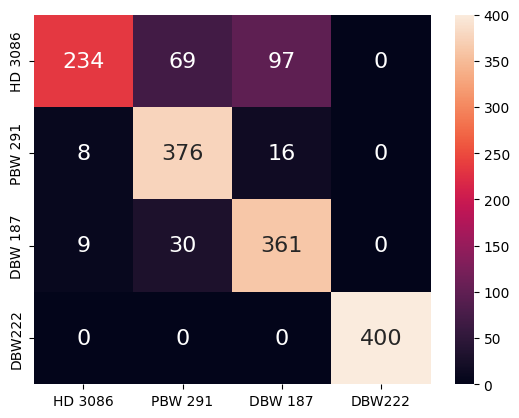

In [38]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()